# YoloV10

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/home/korneel/Documents/rock_detection/yolov10


### Install

In [13]:
!pip install -q supervision

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [7]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [8]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/jameslahm/yolov10/releases/download/v1.0/yolov10l.pt
!ls -lh {HOME}/weights

total 408M
-rw-rw-r-- 1 korneel korneel  80M mei 23 11:38 yolov10b.pt
-rw-rw-r-- 1 korneel korneel 100M mei 23 11:38 yolov10l.pt
-rw-rw-r-- 1 korneel korneel  64M mei 23 11:38 yolov10m.pt
-rw-rw-r-- 1 korneel korneel  11M mei 23 11:38 yolov10n.pt
-rw-rw-r-- 1 korneel korneel  32M mei 23 11:38 yolov10s.pt
-rw-rw-r-- 1 korneel korneel 123M mei 23 11:38 yolov10x.pt


### Pre-trained COCO Model

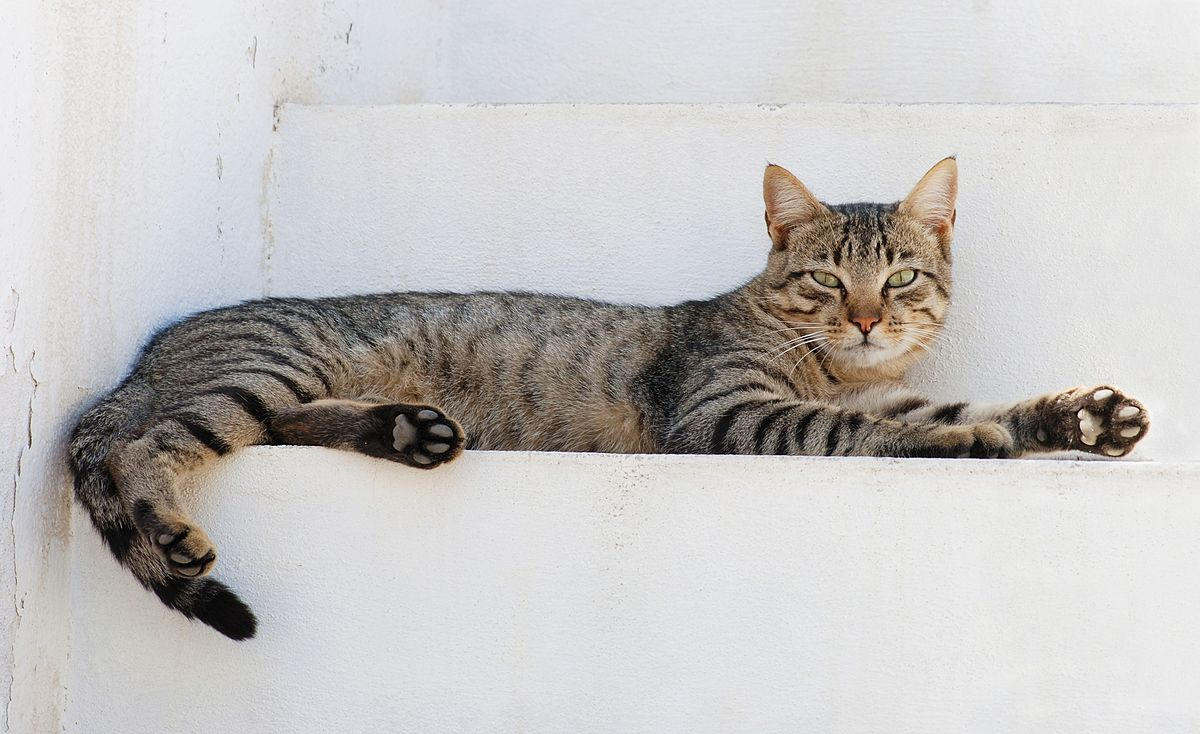

In [2]:
from IPython.display import Image

Image(filename=HOME+'/cat.jpg', height=600)

In [3]:
# %cd {HOME}
# !yolo task=detect mode=predict conf=0.25 save=True model={HOME}/weights/yolov10s.pt source={HOME}/cat.jpg

In [4]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
results = model(source=f'/home/korneel/Documents/rock_detection/yolov10/cat.jpg', conf=0.25)

print(results[0].boxes.xyxy)
print(results[0].boxes.conf)
print(results[0].boxes.cls)


image 1/1 /home/korneel/Documents/rock_detection/yolov10/cat.jpg: 416x640 1 15, 256.1ms
Speed: 8.2ms preprocess, 256.1ms inference, 8.8ms postprocess per image at shape (1, 3, 416, 640)
tensor([[  41.6217,  154.8638, 1156.2764,  467.3195]])
tensor([0.6924])
tensor([15.])



0: 416x640 1 15, 154.9ms
Speed: 5.5ms preprocess, 154.9ms inference, 2.9ms postprocess per image at shape (1, 3, 416, 640)


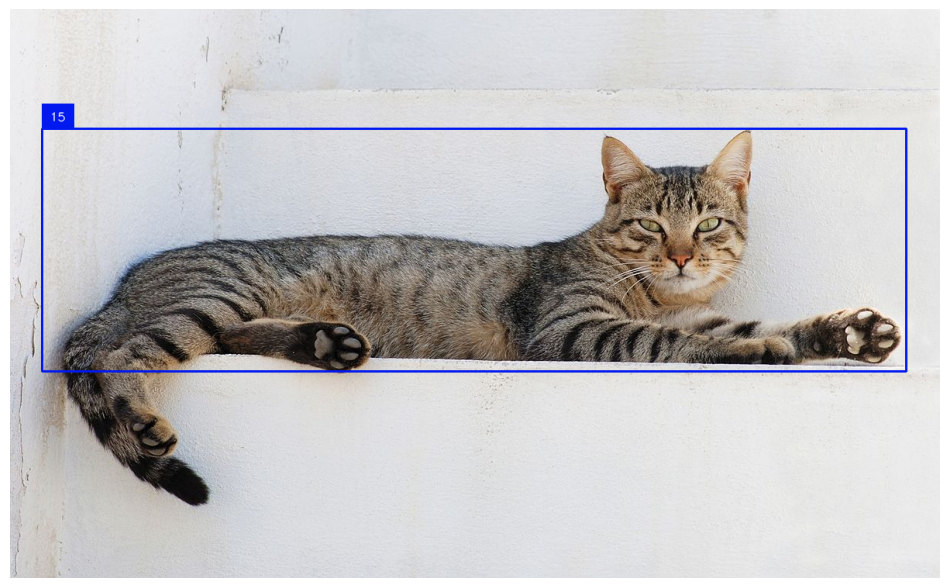

In [5]:
import cv2
import supervision as sv
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/weights/yolov10n.pt')
image = cv2.imread(f'//home/korneel/Documents/rock_detection/yolov10/cat.jpg')
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

### Prepare Dataset

In [9]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil

def prepare_yolo_data(images_folder, csv_file, output_folder, test_size=0.2):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    # Create the output directories
    train_labels_folder = os.path.join(output_folder, 'labels', 'train')
    test_labels_folder = os.path.join(output_folder, 'labels', 'test')
    train_images_folder = os.path.join(output_folder, 'images', 'train')
    test_images_folder = os.path.join(output_folder, 'images', 'test')
    os.makedirs(train_labels_folder, exist_ok=True)
    os.makedirs(test_labels_folder, exist_ok=True)
    os.makedirs(train_images_folder, exist_ok=True)
    os.makedirs(test_images_folder, exist_ok=True)

    # Group the data by image
    grouped = df.groupby('image')
    images = df['image'].unique()

    # Split the images into training and testing sets
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    for image, group in grouped:
        # Prepare the content of the YOLO format label file (YOLO format: class_id center_x center_y width height)
        label_content = []

        # Iterate over the rows of the group (each row corresponds to a bounding box)
        for _, row in group.iterrows():
            class_id = 0
            label_content.append(f"{class_id} {row['center_x']} {row['center_y']} {row['width']} {row['height']}")

        # Determine if the image belongs to the training or testing set
        if image in train_images:
            label_file_path = os.path.join(train_labels_folder, f"{image[:-4]}.txt")
            image_dest_folder = train_images_folder
        else:
            label_file_path = os.path.join(test_labels_folder, f"{image[:-4]}.txt")
            image_dest_folder = test_images_folder

        # Write the label file
        with open(label_file_path, 'w') as f:
            f.write("\n".join(label_content))

        # Copy the corresponding image file to the appropriate output directory
        source_image_path = os.path.join(images_folder, image)
        destination_image_path = os.path.join(image_dest_folder, image)
        if os.path.exists(source_image_path):
            shutil.copy(source_image_path, destination_image_path)

images_folder = HOME + '/raw_input_small'
csv_file = HOME + '/bbox_data_small.csv'
output_folder = HOME + '/yolo_input_small'
prepare_yolo_data(images_folder, csv_file, output_folder)


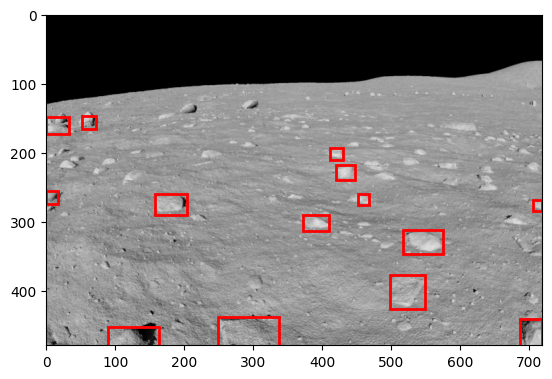

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def plot_random_image_with_bboxes(images_folder, labels_folder):
    # Get a list of all image files in the training folder
    image_files = os.listdir(images_folder)
    
    # Choose a random image
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(images_folder, random_image_file)
    
    # Corresponding label file
    label_file = random_image_file.replace('.png', '.txt')
    label_path = os.path.join(labels_folder, label_file)
    
    # Read the image
    image = Image.open(random_image_path)
    width, height = image.size
    
    # Read the label file
    with open(label_path, 'r') as f:
        bboxes = f.readlines()
    
    # Plot the image
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    # Plot each bounding box
    for bbox in bboxes:
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, bbox.split())
        
        # Convert from YOLO format to matplotlib rectangle format
        x_min = (center_x - bbox_width / 2) * width
        y_min = (center_y - bbox_height / 2) * height
        bbox_width = bbox_width * width
        bbox_height = bbox_height * height
        
        # Create a rectangle patch
        rect = patches.Rectangle((x_min, y_min), bbox_width, bbox_height, linewidth=2, edgecolor='r', facecolor='none')
        
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    plt.show()

# Example usage (replace with your actual paths)
train_images_folder = HOME + '/yolo_input_small/images/train'
train_labels_folder = HOME + '/yolo_input_small/labels/train'
plot_random_image_with_bboxes(train_images_folder, train_labels_folder)

### Train YoloV10 with Custom Dataset

In [13]:
model_path = HOME + '/weights/yolov10l.pt'
data_path = HOME + '/rock.yaml'

!yolo task=detect mode=train epochs=1 batch=4 plots=True \
model={model_path} \
data= {data_path}


New https://pypi.org/project/ultralytics/8.2.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.8.10 torch-2.1.0+cu121 CPU (Intel Core(TM) i7-8750H 2.20GHz)
engine/trainer: task=detect, mode=train, model=/home/korneel/Documents/rock_detection/yolov10/weights/yolov10m.pt, data=/home/korneel/Documents/rock_detection/yolov10/rock.yaml, epochs=1, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize

In [10]:
train_path = HOME + '/runs/detect/train'
!ls {train_path}

args.yaml				   results.png
confusion_matrix_normalized.png		   train_batch0.jpg
confusion_matrix.png			   train_batch1.jpg
events.out.tfevents.1718128941.bob.9678.0  train_batch2.jpg
F1_curve.png				   val_batch0_labels.jpg
labels_correlogram.jpg			   val_batch0_pred.jpg
labels.jpg				   val_batch1_labels.jpg
P_curve.png				   val_batch1_pred.jpg
PR_curve.png				   val_batch2_labels.jpg
R_curve.png				   val_batch2_pred.jpg
results.csv				   weights


/home/korneel/Documents/rock_detection/yolov10


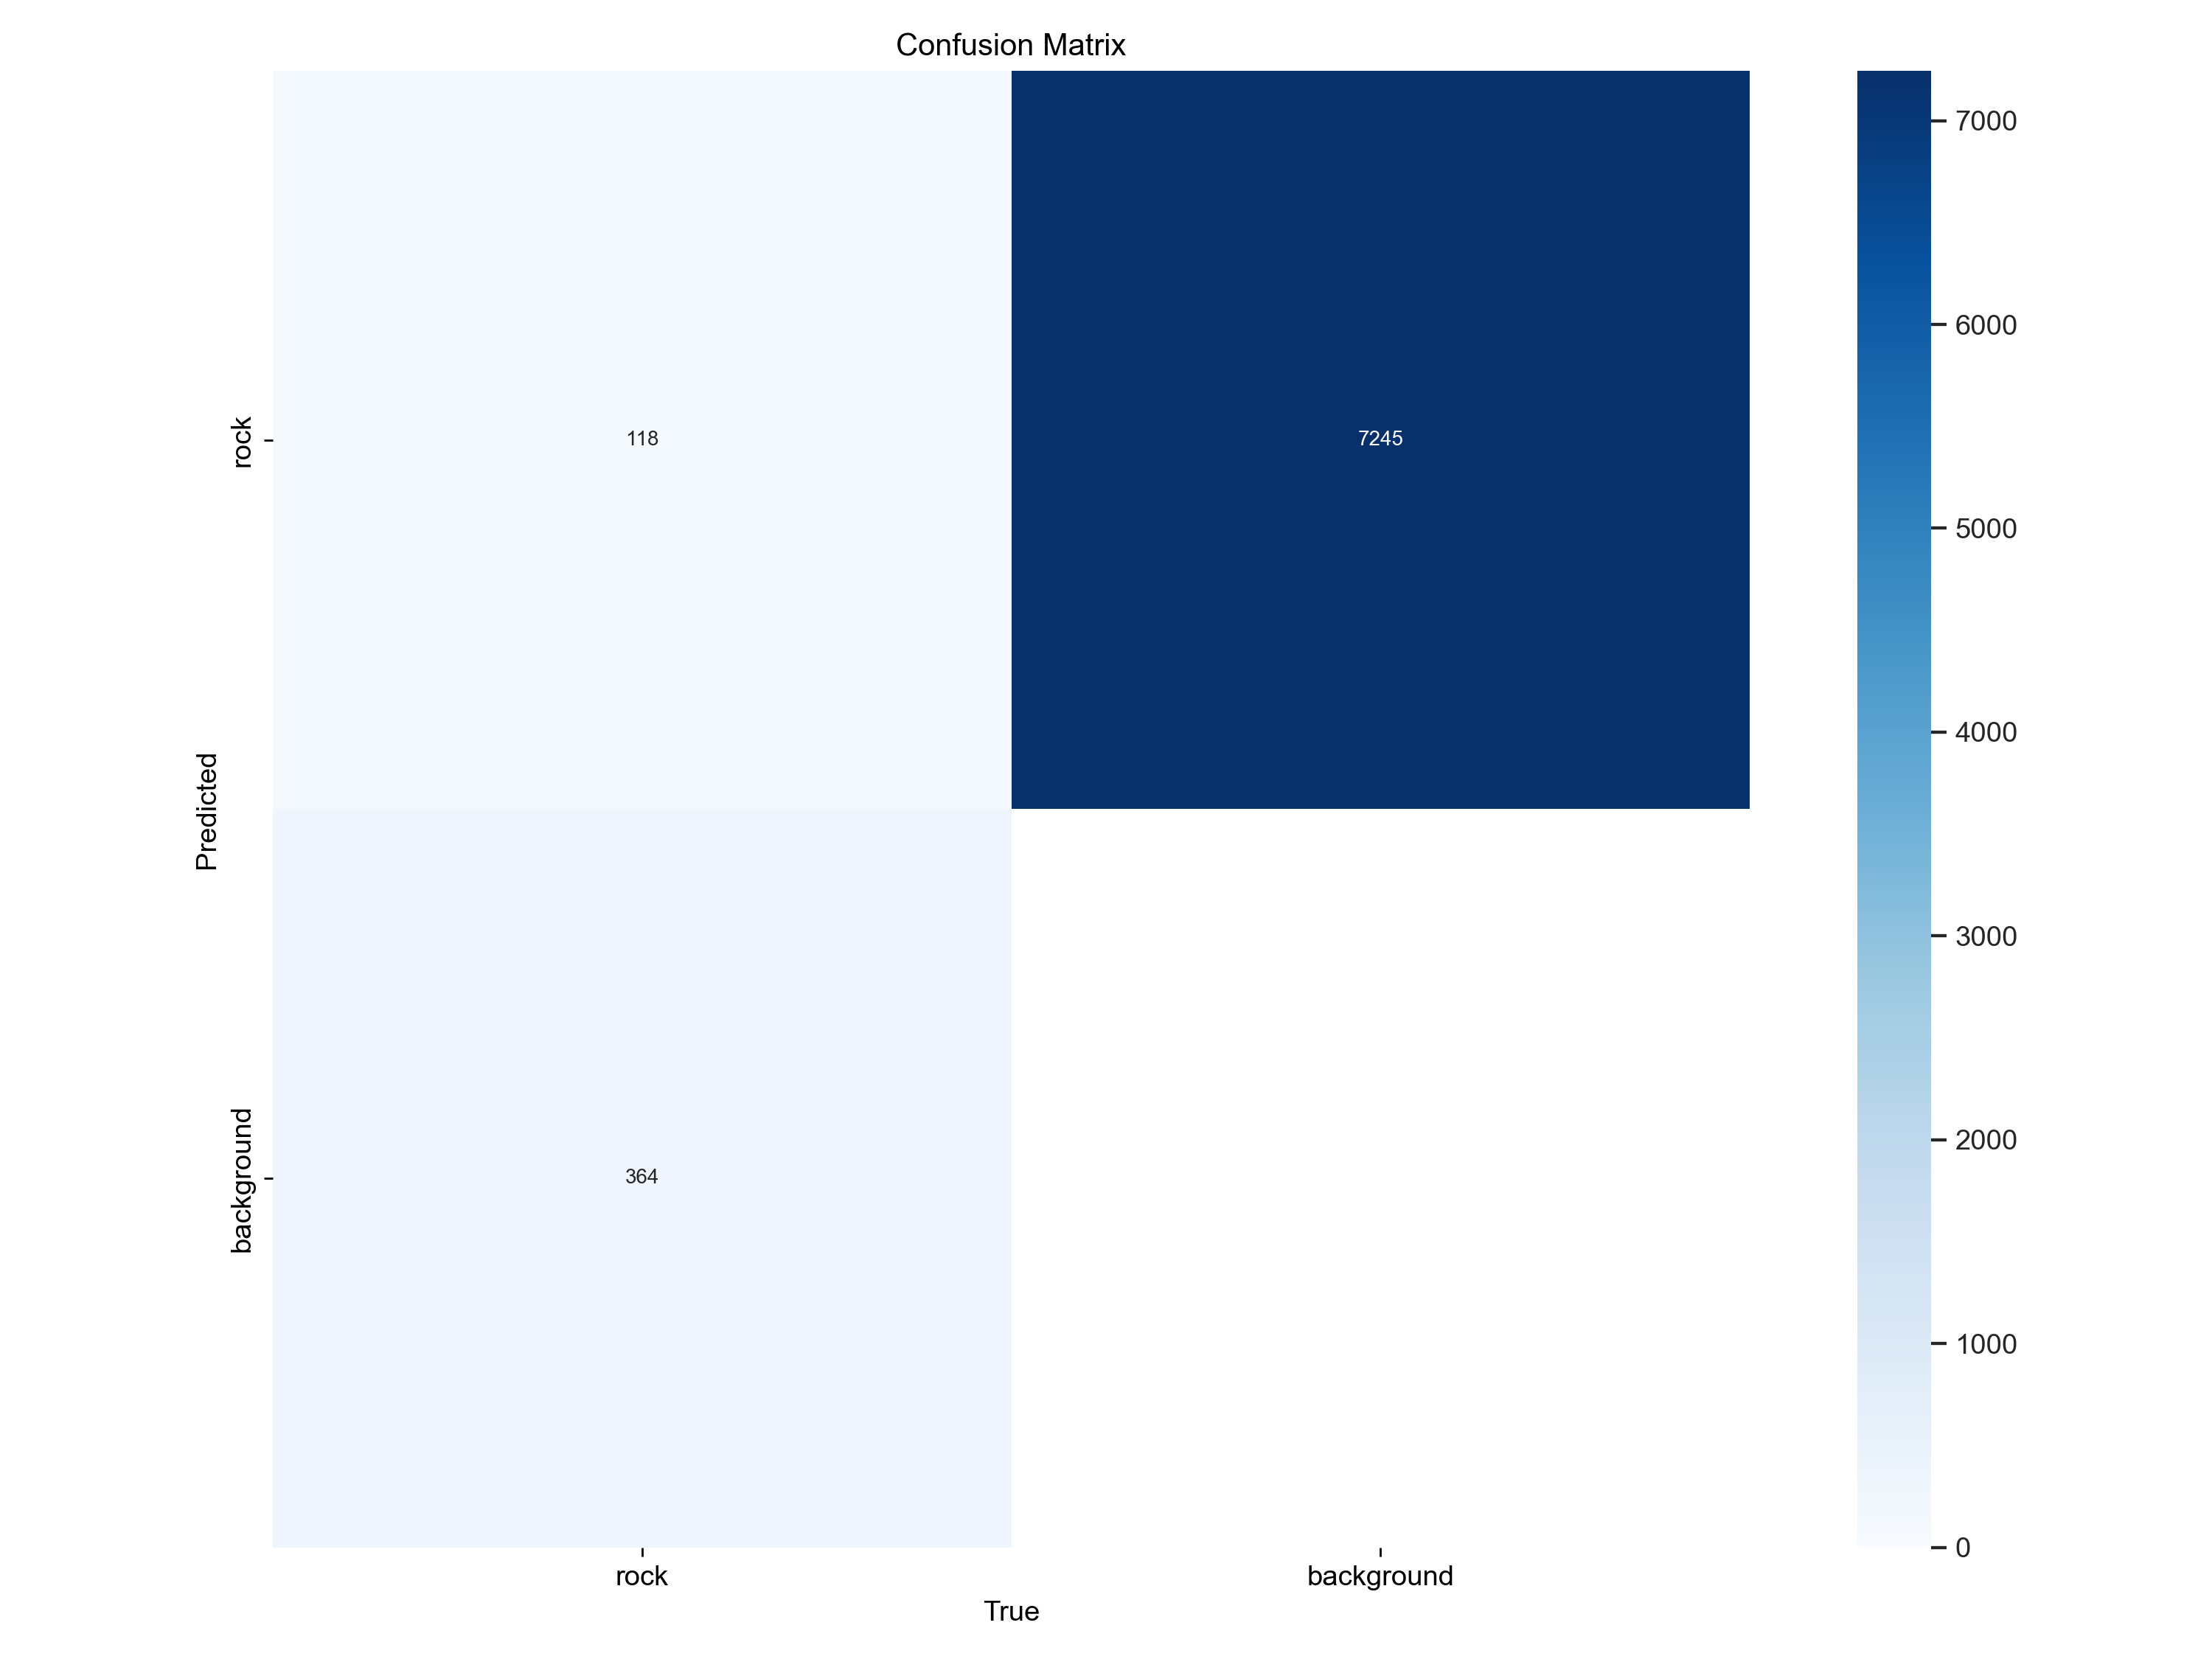

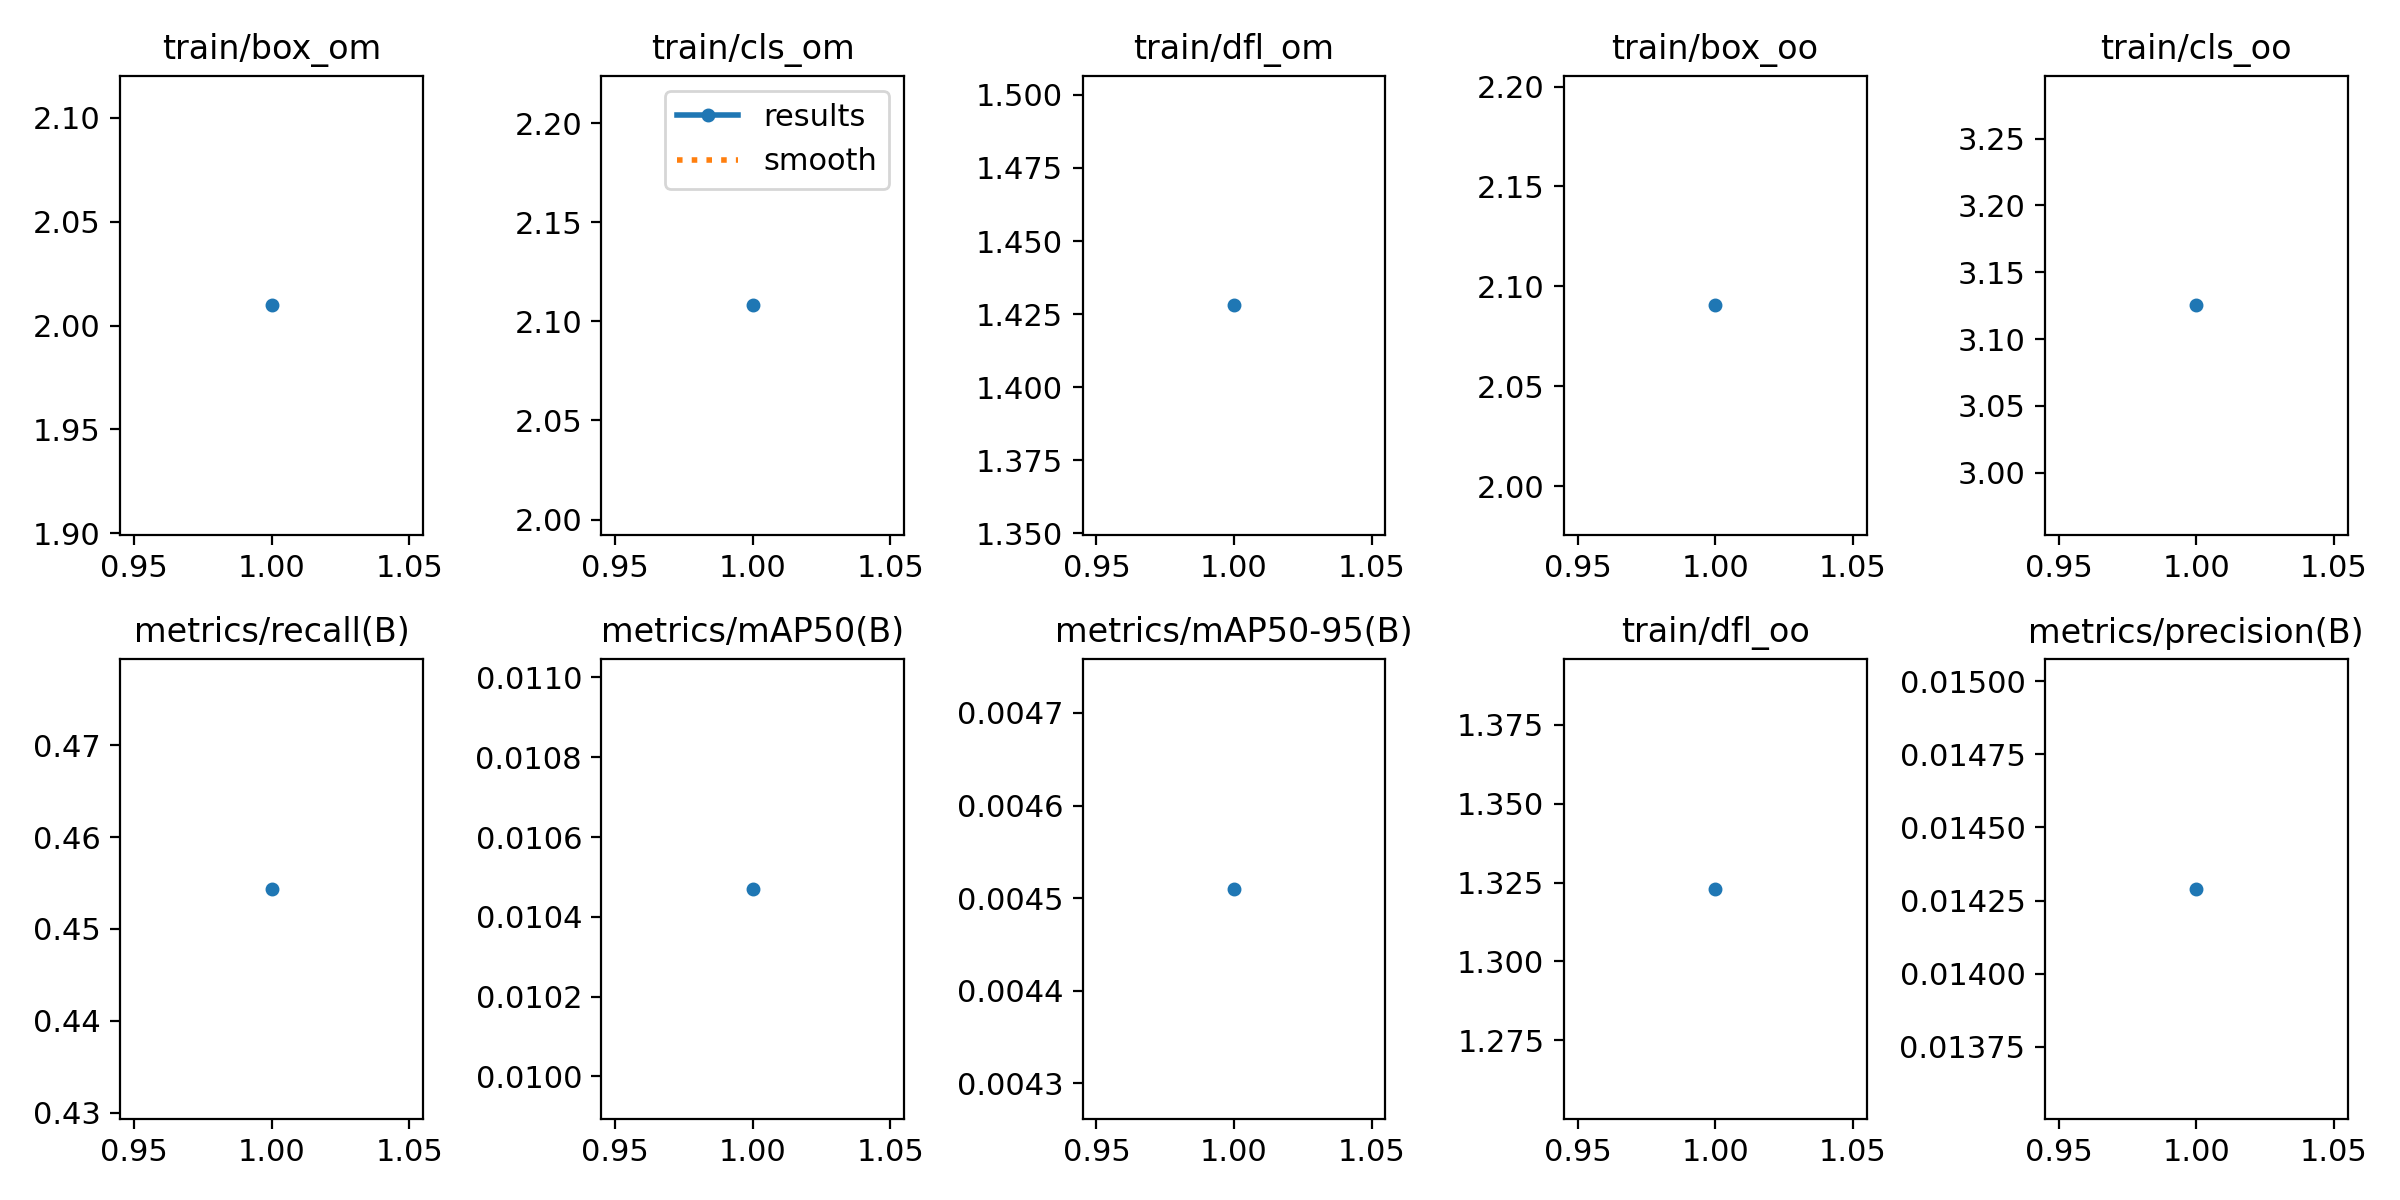

In [11]:
from IPython.display import display, Image

%cd {HOME}

# Define the path for the images
confusion = Image(filename=train_path + '/confusion_matrix.png', width=600)
results = Image(filename=train_path + '/results.png', width=600)

# Display images side by side
display(confusion, results)